# 데이터 EDA

In [64]:
import torch
from ast import literal_eval
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import koreanize_matplotlib
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import hashlib
from kiwipiepy import Kiwi

pd.set_option('display.max_columns', None)

In [ ]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

: 

## 데이터 로드 및 기본 정보

In [ ]:
import pandas as pd
from ast import literal_eval

# 데이터 로드
dataset = pd.read_csv('../data/train_labeled.csv') 

records = []
for _, row in dataset.iterrows():
    # 1. problems 컬럼 파싱 (문자열일 경우 딕셔너리로 변환)
    problems = row['problems']
    if isinstance(problems, str):
        try:
            problems = literal_eval(problems)
        except:
            problems = {} # 파싱 실패 시 빈 딕셔너리
    
    # 2. 데이터 추출 (최상위 컬럼 우선, 없으면 problems 내부 확인)
    # 질문 내용
    q_text = row.get('question') if pd.notna(row.get('question')) else problems.get('question', "")
    
    # 질문 부가 정보 (question_plus)
    q_plus = row.get('question_plus') if pd.notna(row.get('question_plus')) else problems.get('question_plus', None)
    
    # 선택지 및 정답 (보통 problems 내부에 리스트/숫자로 존재)
    choices = problems.get('choices', [])
    answer = problems.get('answer', None)
    
    # 3. 레코드 생성
    record = {
        'id': row['id'],
        'paragraph': row['paragraph'],
        'question': q_text,
        'choices': choices,
        'answer': answer,
        'question_plus': q_plus,
        'subject': row.get('subject', 'unknown'),
        'from': row.get('from', 'unknown')       
    }
    records.append(record)

# 데이터프레임 변환
df = pd.DataFrame(records)

# 결과 확인
print(f"평탄화 완료: 총 {len(df)}개의 문항")
display(df.head())

평탄화 완료: 총 2031개의 문항


,id,paragraph,question,choices,answer,question_plus,subject,from
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None,korean_history,KMMLU
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None,korean_history,KMMLU
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None,korean_history,KMMLU
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None,korean_history,KMMLU
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None,korean_history,KMMLU


: 

In [ ]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
id                  0
paragraph           0
question            0
choices             0
answer              0
question_plus    2031
subject             0
from                0
dtype: int64


: 

In [ ]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             2031 non-null   object
 1   paragraph      2031 non-null   object
 2   question       2031 non-null   object
 3   choices        2031 non-null   object
 4   answer         2031 non-null   int64 
 5   question_plus  0 non-null      object
 6   subject        2031 non-null   object
 7   from           2031 non-null   object
dtypes: int64(1), object(7)
memory usage: 127.1+ KB


: 

## 데이터 기본 분포 확인

/tmp/ipykernel_108931/3213433490.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='subject', data=df_dist, ax=axes[1, 0], order=subject_order, palette='magma')
/tmp/ipykernel_108931/3213433490.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='answer', data=df_dist, ax=axes[2, 0], palette='viridis')


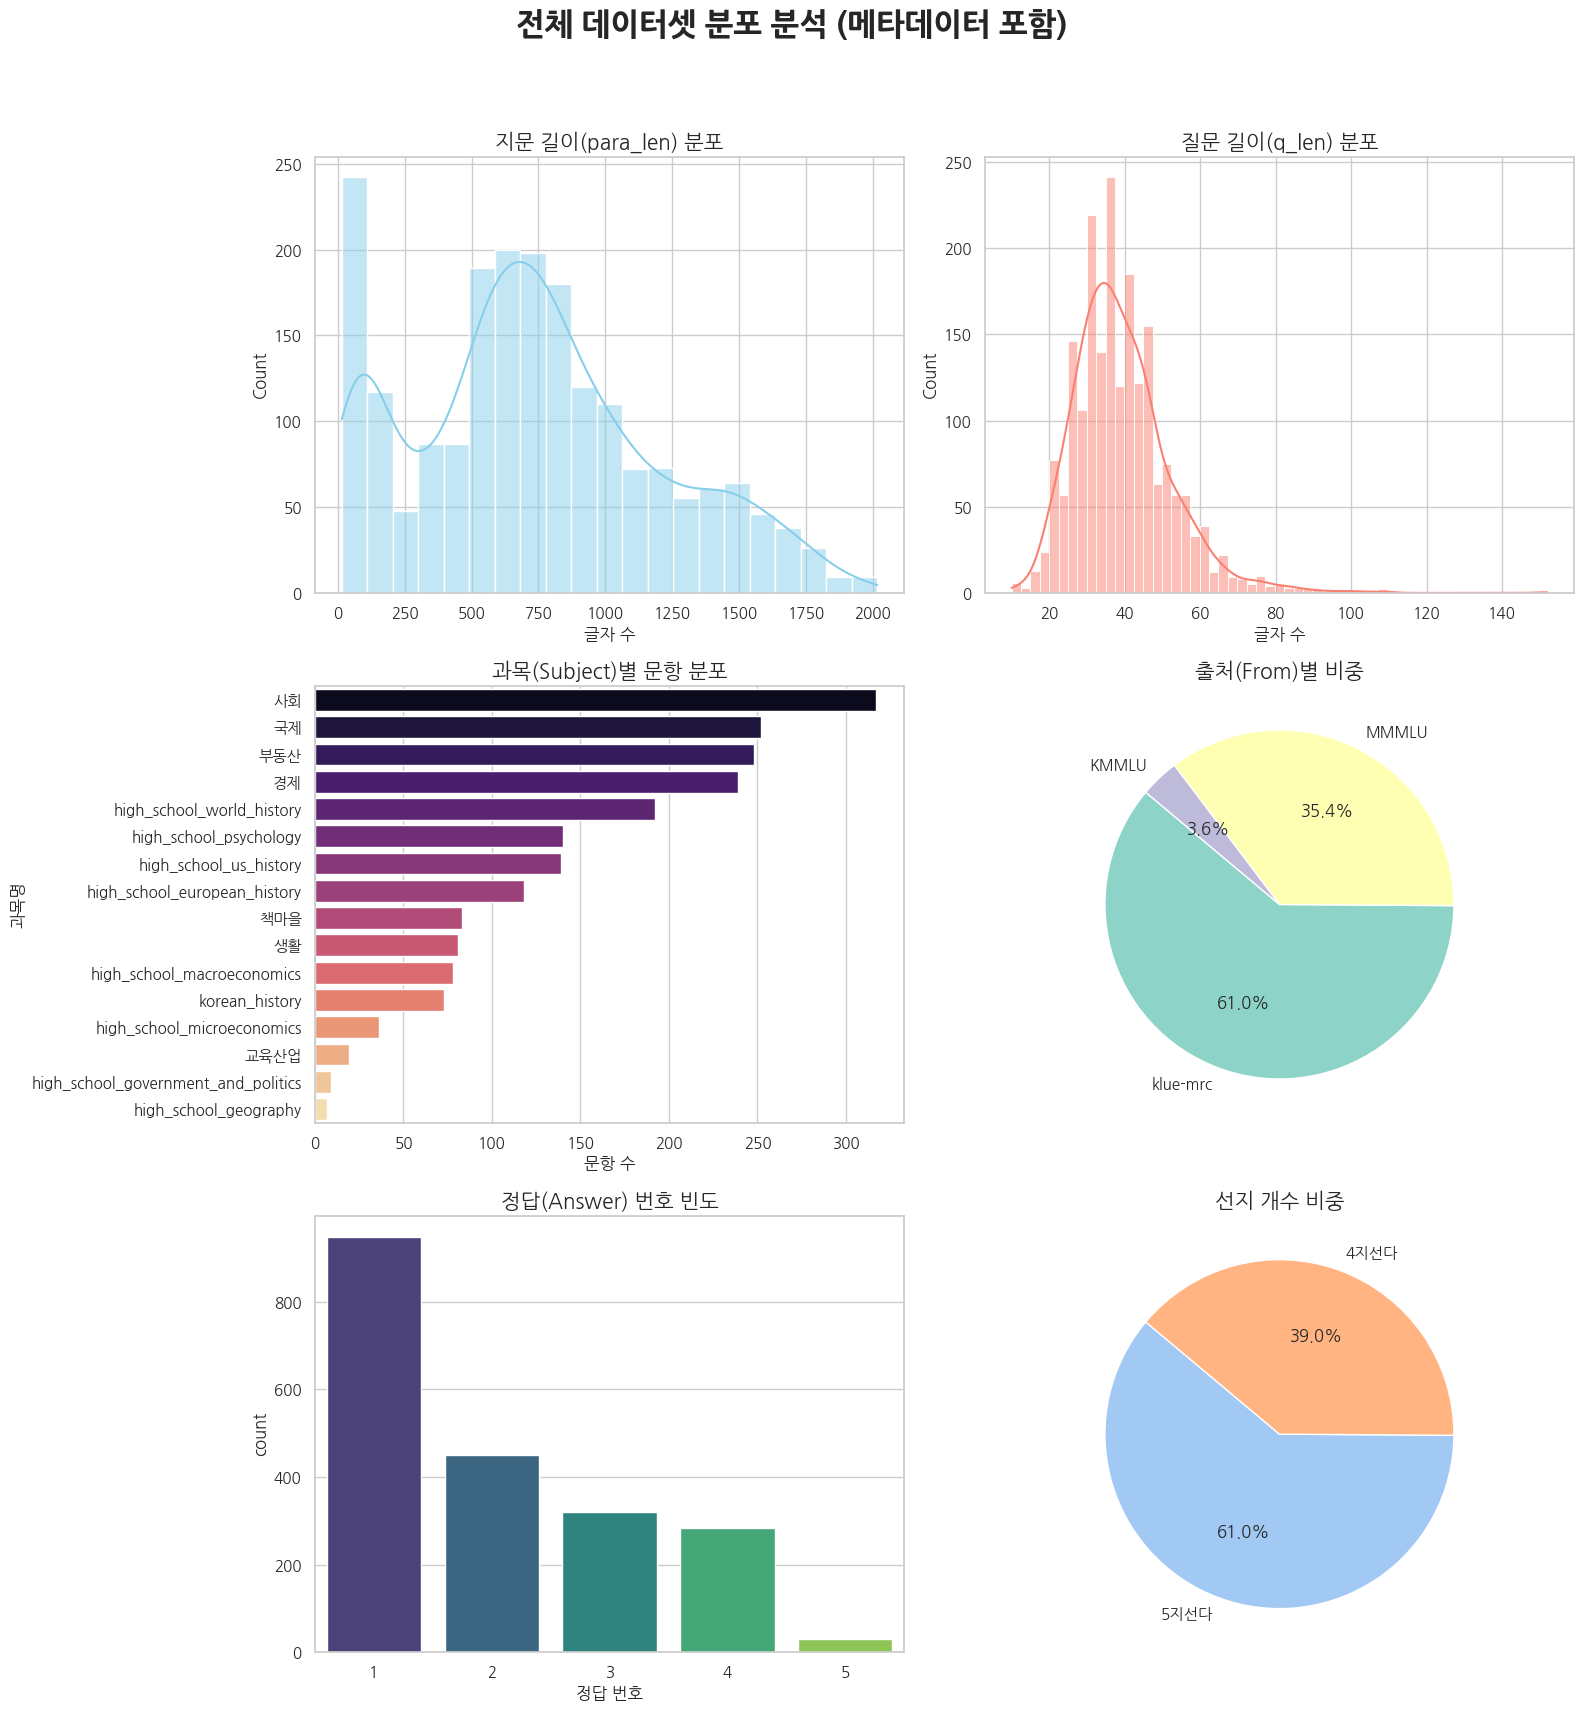

### 전체 데이터셋 주요 통계량 ###


,para_len,q_len,num_choices
count,2031.00,2031.00,2031.00
mean,735.33,39.24,4.61
std,462.59,12.98,0.49
min,15.00,10.00,4.00
25%,407.50,30.00,4.00
50%,699.00,37.00,5.00
75%,1014.50,46.00,5.00
max,2017.00,152.00,5.00



### 범주형 데이터 빈도 (Top 5) ###
------------------------------
[과목 분포]
 subject
사회                           317
국제                           252
부동산                          248
경제                           239
high_school_world_history    192
Name: count, dtype: int64

[출처 분포]
 from
klue-mrc    1239
MMMLU        719
KMMLU         73
Name: count, dtype: int64


: 

In [ ]:
# 시각화 스타일 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic' # 윈도우 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

# 1. 시각화할 피처 추가 계산
df_dist = df.copy()
df_dist['para_len'] = df_dist['paragraph'].apply(lambda x: len(str(x)) if x else 0)
df_dist['q_len'] = df_dist['question'].apply(lambda x: len(str(x)) if x else 0)
df_dist['num_choices'] = df_dist['choices'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# 2. 서브플롯 구성 (3x2 레이아웃으로 변경)
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('전체 데이터셋 분포 분석 (메타데이터 포함)', fontsize=22, fontweight='bold', y=0.98)

# (1) 지문 길이 분포
sns.histplot(df_dist['para_len'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('지문 길이(para_len) 분포', fontsize=15)
axes[0, 0].set_xlabel('글자 수')

# (2) 질문 길이 분포
sns.histplot(df_dist['q_len'], kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('질문 길이(q_len) 분포', fontsize=15)
axes[0, 1].set_xlabel('글자 수')

# (3) [추가] 과목별 문항 수 (subject)
# 빈도가 높은 순서대로 정렬하여 표시
subject_order = df_dist['subject'].value_counts().index
sns.countplot(y='subject', data=df_dist, ax=axes[1, 0], order=subject_order, palette='magma')
axes[1, 0].set_title('과목(Subject)별 문항 분포', fontsize=15)
axes[1, 0].set_xlabel('문항 수')
axes[1, 0].set_ylabel('과목명')

# (4) [추가] 출처별 비중 (from) - 파이 차트
from_counts = df_dist['from'].value_counts()
axes[1, 1].pie(from_counts, labels=from_counts.index, 
                autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3'))
axes[1, 1].set_title('출처(From)별 비중', fontsize=15)

# (5) 정답(answer) 번호 빈도
sns.countplot(x='answer', data=df_dist, ax=axes[2, 0], palette='viridis')
axes[2, 0].set_title('정답(Answer) 번호 빈도', fontsize=15)
axes[2, 0].set_xlabel('정답 번호')

# (6) 선지 개수 분포 - 파이 차트
choice_counts = df_dist['num_choices'].value_counts()
axes[2, 1].pie(choice_counts, labels=[f'{int(i)}지선다' for i in choice_counts.index], 
                autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
axes[2, 1].set_title('선지 개수 비중', fontsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 3. 주요 통계치 요약 출력 (subject와 from 빈도 포함)
print("### 전체 데이터셋 주요 통계량 ###")
summary = df_dist[['para_len', 'q_len', 'num_choices']].describe().round(2)
display(summary)

print("\n### 범주형 데이터 빈도 (Top 5) ###")
print("-" * 30)
print("[과목 분포]\n", df_dist['subject'].value_counts().head())
print("\n[출처 분포]\n", df_dist['from'].value_counts().head())

## 출처 별 정답 빈도

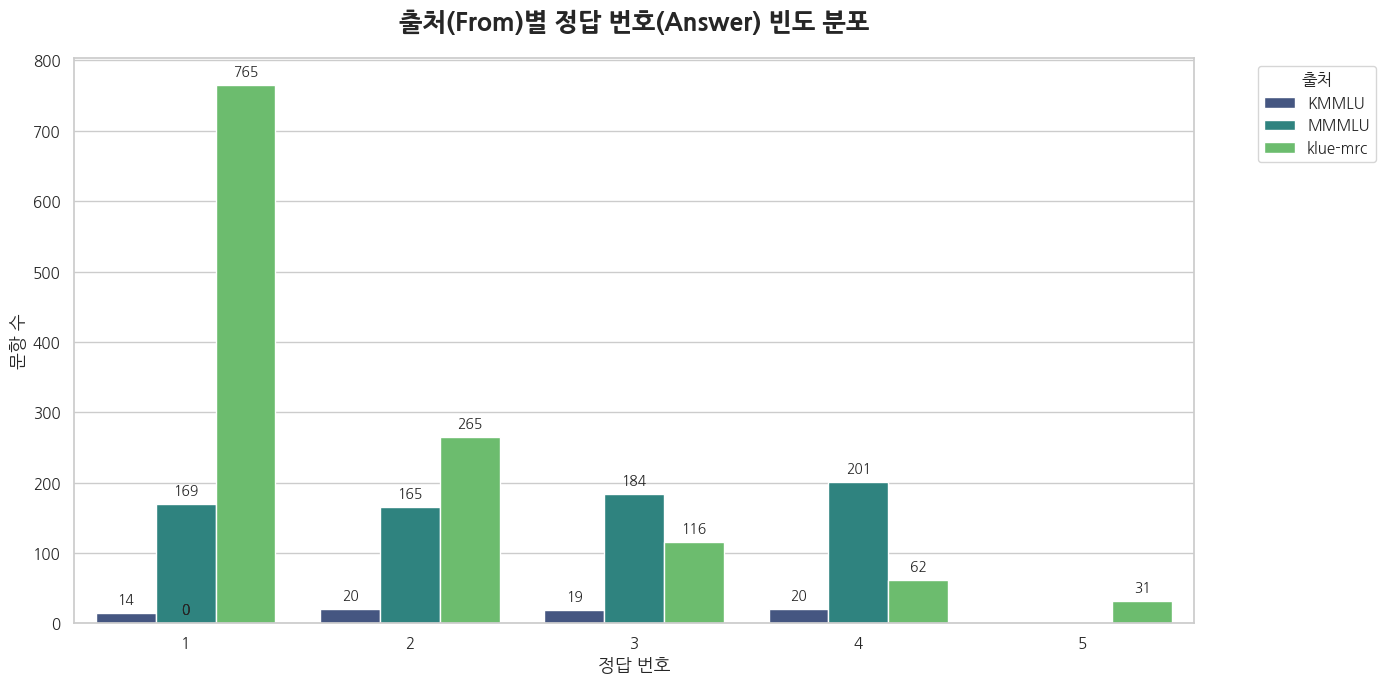

<<<출처별 정답 번호 상세 빈도표>>>


answer,1,2,3,4,5
from,,,,,
KMMLU,14,20,19,20,0
MMMLU,169,165,184,201,0
klue-mrc,765,265,116,62,31


: 

In [ ]:
# 1. 시각화 스타일 및 폰트 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic' # 윈도우 한글 설정
plt.rcParams['axes.unicode_minus'] = False

# 2. 그래프 생성
plt.figure(figsize=(14, 7))

# hue='from'을 사용하여 정답 번호(1~5)별로 출처가 나란히 보이게 설정
ax = sns.countplot(x='answer', hue='from', data=df, palette='viridis')

# 3. 타이틀 및 라벨 설정
plt.title('출처(From)별 정답 번호(Answer) 빈도 분포', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('정답 번호', fontsize=13)
plt.ylabel('문항 수', fontsize=13)
plt.legend(title='출처', bbox_to_anchor=(1.05, 1), loc='upper left') # 범례를 그래프 밖으로 이동

# 4. 막대 위에 숫자 표시 (선택 사항)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

# 5. 수치 데이터로 확인 (Cross-tabulation)
print("<<<출처별 정답 번호 상세 빈도표>>>")
cross_tab = pd.crosstab(df['from'], df['answer'])
display(cross_tab)

## 오답지의 매력도 (S-BERT)
왕 == 군주와 같은 의미 기반

In [ ]:
# 1. 모델 로드 (한국어 성능이 우수한 S-BERT 모델)
model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

def calculate_hybrid_attractiveness_sbert(row):
    p_text = str(row['paragraph'])
    choices = row['choices'] if isinstance(row['choices'], list) else []
    answer_idx = int(row['answer']) - 1
    
    if not choices or len(choices) < 2:
        return 0.0

    # --- [Step 1] 조합형 문제 확인 및 텍스트 추출 ---
    # 지문에 'ㄱ.' 형태의 패턴이 있는지 검사
    is_combination = bool(re.search(r'[ㄱ-ㅎ]\s*[\.|\:|\]|\)]', p_text))

    if is_combination:
        # 지문 하단 기호(ㄱ, ㄴ, ㄷ...) 뒤의 실제 텍스트 내용 추출
        tag_content = {}
        tags = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ']
        for i in range(len(tags)-1):
            pattern = fr"{tags[i]}\s*[\.|\:|\]|\)]+\s*(.*?)(?={tags[i+1]}|\Z)"
            match = re.search(pattern, p_text, re.S)
            if match:
                tag_content[tags[i]] = match.group(1).strip()
        
        # 선택지 기호를 실제 문장으로 치환하여 합성
        processed_choices = []
        for c in choices:
            actual_text = ""
            for tag, content in tag_content.items():
                if tag in str(c):
                    actual_text += content + " "
            processed_choices.append(actual_text.strip() if actual_text else str(c))
    else:
        # 일반 문항은 선택지 텍스트 그대로 사용
        processed_choices = [str(c) for c in choices]

    # --- [Step 2] S-BERT 임베딩 생성 ---
    # 선택지 전체를 벡터화
    choice_embeddings = model.encode(processed_choices)
    
    # 지문 텍스트 벡터화 (조합형인 경우 기호 부분 제외하고 본문만 추출)
    clean_p_text = re.sub(r'[ㄱ-ㅎ]\s*[\.|\:|\]|\)].*', '', p_text, flags=re.S) if is_combination else p_text
    p_embedding = model.encode([clean_p_text])
    
    # 정답 벡터 추출
    answer_embedding = choice_embeddings[answer_idx].reshape(1, -1)
    
    distractor_scores = []
    
    # --- [Step 3] 오답별 매력도 계산 ---
    for i, c_emb in enumerate(choice_embeddings):
        if i == answer_idx: 
            continue  # 정답은 계산에서 제외
        
        c_emb = c_emb.reshape(1, -1)
        
        # A) 정답과의 유사도 (재진술/말바꾸기 함정)
        sim_with_answer = cosine_similarity(c_emb, answer_embedding)[0][0]
        
        # B) 지문 본문과의 유사도 (단어 낚시 함정)
        sim_with_para = cosine_similarity(c_emb, p_embedding)[0][0]
        
        # 두 유사도 중 더 높은 것을 해당 오답의 '매력도'로 간주
        distractor_scores.append(max(sim_with_answer, sim_with_para))
    
    # 해당 문항에서 가장 매력적인 오답의 점수를 반환
    return float(np.max(distractor_scores)) if distractor_scores else 0.0

# 2. 데이터프레임에 적용
print("S-BERT 하이브리드 모드로 오답 매력도 계산 중...")
df['distractor_attractiveness'] = df.apply(calculate_hybrid_attractiveness_sbert, axis=1)
print("계산 완료! 'distractor_attractiveness' 컬럼이 추가되었습니다.")

/data/ephemeral/home/moon/csat/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


S-BERT 하이브리드 모드로 오답 매력도 계산 중...
계산 완료! 'distractor_attractiveness' 컬럼이 추가되었습니다.


: 

## 오답지의 매력도(SimHash)
단어 기반

In [ ]:
def get_simhash(text):
    """텍스트의 SimHash 값을 64비트 정수로 생성"""
    if not text or len(str(text).strip()) == 0:
        return 0
    
    # 1. 특징 추출 (단어 단위 분절)
    features = str(text).split()
    v = [0] * 64  # 64비트 해시 벡터
    
    for f in features:
        # 각 단어의 고유 해시값 생성 (MD5 활용)
        t = int(hashlib.md5(f.encode('utf-8')).hexdigest(), 16)
        for i in range(64):
            bitmask = 1 << i
            if t & bitmask:
                v[i] += 1  # 비트가 1이면 가중치 증가
            else:
                v[i] -= 1  # 비트가 0이면 가중치 감소
                
    # 2. 결과 비트 생성
    fingerprint = 0
    for i in range(64):
        if v[i] >= 0:
            fingerprint |= (1 << i)
            
    return fingerprint

def get_hamming_similarity(hash1, hash2):
    """해밍 거리를 이용한 유사도 산출 (0~1 사이)"""
    # XOR 연산 후 1의 개수를 세어 해밍 거리를 구함
    x = hash1 ^ hash2
    hamming_dist = bin(x).count('1')
    # 64비트 기준 유사도로 변환 (거리가 0이면 유사도 1)
    return 1 - (hamming_dist / 64)

def calculate_simhash_attractiveness(row):
    p_text = str(row['paragraph'])
    choices = row['choices'] if isinstance(row['choices'], list) else []
    answer_idx = int(row['answer']) - 1
    
    if not choices or len(choices) < 2:
        return 0.0

    # --- [Step 1] 하이브리드 텍스트 추출 (조합형 여부 판단) ---
    is_combination = bool(re.search(r'[ㄱ-ㅎ]\s*[\.|\:|\]|\)]', p_text))
    processed_choices = []

    if is_combination:
        tag_content = {}
        tags = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ']
        for i in range(len(tags)-1):
            pattern = fr"{tags[i]}\s*[\.|\:|\]|\)]+\s*(.*?)(?={tags[i+1]}|\Z)"
            match = re.search(pattern, p_text, re.S)
            if match: tag_content[tags[i]] = match.group(1).strip()
        
        for c in choices:
            actual_text = " ".join([tag_content[tag] for tag in tag_content if tag in str(c)])
            processed_choices.append(actual_text if actual_text else str(c))
    else:
        processed_choices = [str(c) for c in choices]

    # --- [Step 2] SimHash 기반 유사도 계산 ---
    choice_hashes = [get_simhash(c) for c in processed_choices]
    p_hash = get_simhash(p_text)
    ans_hash = choice_hashes[answer_idx]
    
    distractor_scores = []
    for i, dist_hash in enumerate(choice_hashes):
        if i == answer_idx: continue
        
        # 정답 해시와 비교 + 지문 해시와 비교
        sim_with_ans = get_hamming_similarity(dist_hash, ans_hash)
        sim_with_p = get_hamming_similarity(dist_hash, p_hash)
        
        distractor_scores.append(max(sim_with_ans, sim_with_p))
        
    return float(np.max(distractor_scores)) if distractor_scores else 0.0

# 데이터 적용
df['distractor_attractiveness_simhash'] = df.apply(calculate_simhash_attractiveness, axis=1)

: 

## 오답지의 매력도(통합)

의미기반과 단어기반을 비교했을때, 가장 큰 유사도를 가지는 점수로 선정

In [ ]:
def calculate_final_distractor_attractiveness(row):
    p_text = str(row['paragraph']) if row['paragraph'] else ""
    choices = row['choices'] if isinstance(row['choices'], list) else []
    answer = row.get('answer')
    
    if not choices or not answer or not p_text.strip():
        return 0.0
    
    try:
        answer_idx = int(answer) - 1
        ans_text = str(choices[answer_idx])
        distractors = [str(c) for i, c in enumerate(choices) if i != answer_idx]
        
        # --- 1. 임베딩(S-BERT) 기반 매력도 ---
        # 선지들과 (정답 + 지문) 간의 의미적 유사도 측정
        p_embedding = model.encode([p_text])
        ans_embedding = model.encode([ans_text])
        dist_embeddings = model.encode(distractors)
        
        # 오답이 정답과 비슷하거나, 지문과 비슷할수록 매력적임
        sim_with_ans_emb = cosine_similarity(dist_embeddings, ans_embedding)
        sim_with_p_emb = cosine_similarity(dist_embeddings, p_embedding)
        
        # 각 오답별로 (정답유사도, 지문유사도) 중 큰 값을 취함
        emb_scores = np.maximum(sim_with_ans_emb, sim_with_p_emb)
        max_emb_score = float(np.max(emb_scores))

        # --- 2. SimHash 기반 매력도 (자구적 유사도) ---
        def get_simhash_val(text):
            features = str(text).split()
            v = [0] * 64
            for f in features:
                t = int(hashlib.md5(f.encode('utf-8')).hexdigest(), 16)
                for i in range(64):
                    if t & (1 << i): v[i] += 1
                    else: v[i] -= 1
            fingerprint = 0
            for i in range(64):
                if v[i] >= 0: fingerprint |= (1 << i)
            return fingerprint

        def hamming_sim(h1, h2):
            return 1 - (bin(h1 ^ h2).count('1') / 64)

        p_hash = get_simhash_val(p_text)
        ans_hash = get_simhash_val(ans_text)
        dist_hashes = [get_simhash_val(d) for d in distractors]
        
        sh_scores = [max(hamming_sim(dh, ans_hash), hamming_sim(dh, p_hash)) for dh in dist_hashes]
        max_sh_score = float(np.max(sh_scores))

        # --- 3. 최종 결합 (Ensemble) ---
        # 두 점수 중 높은 것을 취하거나 가중 평균 사용
        # 여기서는 두 측면 중 하나라도 높으면 매력적인 오답으로 판단 (Max 방식)
        final_score = max(max_emb_score, max_sh_score)
        
        return final_score

    except Exception as e:
        return 0.0

# 피처 적용
print("임베딩 + SimHash 통합 오답 매력도 계산 중...")
df['final_distractor_attractiveness'] = df.apply(calculate_final_distractor_attractiveness, axis=1)

임베딩 + SimHash 통합 오답 매력도 계산 중...


: 

## 4지선다 or 5지선다

In [ ]:
import pandas as pd

# 1. 선지 리스트의 길이를 계산하여 'num_choices' 열 생성
# choices 컬럼이 리스트 형태인 경우 len()을 사용하고, 
# 만약 결측치(NaN)가 있다면 0으로 처리합니다.
df['num_choices'] = df['choices'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# 2. 결과 확인: 4지선다와 5지선다의 분포 확인
print("### 선지 개수별 문항 분포 ###")
print(df['num_choices'].value_counts().sort_index())

# 3. 데이터 샘플 확인
display(df[['id', 'choices', 'num_choices']].head())

### 선지 개수별 문항 분포 ###
num_choices
4     792
5    1239
Name: count, dtype: int64


,id,choices,num_choices
0,generation-for-nlp-425,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",4
1,generation-for-nlp-426,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",4
2,generation-for-nlp-427,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4
3,generation-for-nlp-428,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",4
4,generation-for-nlp-429,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",4


: 

In [ ]:
df.head()

,id,paragraph,question,choices,answer,question_plus,subject,from,distractor_attractiveness,distractor_attractiveness_simhash,final_distractor_attractiveness,num_choices
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None,korean_history,KMMLU,0.805455,0.703125,0.858223,4
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None,korean_history,KMMLU,0.478597,0.656250,0.656250,4
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None,korean_history,KMMLU,0.409381,0.656250,0.656250,4
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None,korean_history,KMMLU,0.516401,0.750000,0.750000,4
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None,korean_history,KMMLU,0.468751,0.656250,0.656250,4


: 

## LQ 지수를 위한 피처 생성
`avg_words_per_sent` == 문장 당 평균 어절 수 (높을수록 통사적 구조가 복잡)

`num_paragraphs` == 문단 수

`lq_ttr` == 어휘 다양성 (동일단어의 반복이 적고 새 단어가 많을수록 높음)

`lq_term_density` == 전문 용어의 밀도 (높을수록 배경지식 요구도 높음)

`lq_modifier_ratio`== 관형사/부사 비중 (높을수록 수식 관계가 정교하고 복잡)

`lq_score` == 최종 언어 복잡도 점수 (`avg_words_per_sent` + `lq_ttr` + `lq_term_density` + `lq_modifier_ratio`)

In [ ]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

def calculate_lq_features(row):
    p_text = str(row['paragraph']).strip() if pd.notna(row['paragraph']) else ""
    if not p_text:
        return pd.Series([0.0] * 6)

    try:
        # --- [A] 기초 언어적 분석 ---
        sentences = kiwi.split_into_sents(p_text)
        num_sentences = len(sentences)
        words = p_text.split()
        avg_words_per_sent = len(words) / num_sentences if num_sentences > 0 else 0
        num_paragraphs = len([p for p in p_text.split('\n') if p.strip()])
        
        # --- [B] 형태소 분석 ---
        tokens = kiwi.tokenize(p_text)
        nouns = [t.form for t in tokens if t.tag.startswith('N')]
        unique_nouns = [n for n in nouns if len(n) >= 3] 
        modifiers = [t.form for t in tokens if t.tag in ['MM', 'MAG']]
        
        # --- [C] LQ 지수 관련 피처 ---
        ttr = len(set(nouns)) / len(nouns) if len(nouns) > 0 else 0
        term_density = len(unique_nouns) / len(words) if len(words) > 0 else 0
        modifier_ratio = len(modifiers) / len(words) if len(words) > 0 else 0
        lq_score = (avg_words_per_sent * 0.4) + (term_density * 30) + (modifier_ratio * 10) + (ttr * 5)

        return pd.Series([avg_words_per_sent, num_paragraphs, ttr, term_density, modifier_ratio, lq_score])
    except Exception as e:
        return pd.Series([0.0] * 6)

# LQ 피처 적용
lq_cols = ['avg_words_per_sent', 'num_paragraphs', 'lq_ttr', 'lq_term_density', 'lq_modifier_ratio', 'lq_score']
df[lq_cols] = df.apply(calculate_lq_features, axis=1)

: 

## 추론 난이도 관련 피처 생성
`q_p_similarity` == 질문과 지문의 텍스트 유사도 (높을 수록 추론형 문항일 확률이 높음)

`choice_p_similarity` == 보기와 지문의 텍스트 유사도 (높을 수록 추론형 문항일 확률이 높음)

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 모델 로드 (이미 로드되어 있다면 생략 가능)
# model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

def calculate_embedding_similarities(row):
    p_text = str(row['paragraph']).strip() if pd.notna(row['paragraph']) else ""
    q_text = str(row['question']).strip() if pd.notna(row['question']) else ""
    choices = row['choices'] if isinstance(row['choices'], list) else []
    
    if not p_text:
        return pd.Series([0.0, 0.0])

    try:
        # 지문 임베딩 (공통 사용)
        p_embedding = model.encode([p_text], show_progress_bar=False)
        
        # 1. 질문-지문 유사도 계산
        q_embedding = model.encode([q_text], show_progress_bar=False)
        q_p_sim = float(cosine_similarity(p_embedding, q_embedding)[0][0])
        
        # 2. 선지-지문 유사도(추론 깊이) 계산
        if choices:
            c_embeddings = model.encode([str(c) for c in choices], show_progress_bar=False)
            choice_p_sims = cosine_similarity(c_embeddings, p_embedding)
            choice_p_sim = float(np.mean(choice_p_sims))
        else:
            choice_p_sim = 0.0
            
        return pd.Series([q_p_sim, choice_p_sim])
    except Exception as e:
        return pd.Series([0.0, 0.0])

# 데이터프레임 적용
print("임베딩 기반 유사도(질문, 선지) 계산 중...")
df[['q_p_similarity', 'choice_p_similarity']] = df.apply(calculate_embedding_similarities, axis=1)

임베딩 기반 유사도(질문, 선지) 계산 중...


: 

## 질문 유형 관련 피처 생성
`is_negative` == 부정형 질문 여부

In [ ]:
def check_is_negative(row):
    q_text = str(row['question']).strip() if pd.notna(row['question']) else ""
    
    # 부정형 질문 키워드 리스트
    negative_keywords = ['않은', '못한', '없는', '틀린', '아닌', '적절하지', '거리가 먼']
    
    # 키워드가 하나라도 포함되면 1, 아니면 0
    return 1 if any(word in q_text for word in negative_keywords) else 0

# 데이터프레임 적용
print("부정 질문 여부 판별 중...")
df['is_negative'] = df.apply(check_is_negative, axis=1)

부정 질문 여부 판별 중...


: 

In [ ]:
df.head()

,id,paragraph,question,choices,answer,question_plus,subject,from,distractor_attractiveness,distractor_attractiveness_simhash,final_distractor_attractiveness,num_choices,avg_words_per_sent,num_paragraphs,lq_ttr,lq_term_density,lq_modifier_ratio,lq_score,q_p_similarity,choice_p_similarity,is_negative
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None,korean_history,KMMLU,0.805455,0.703125,0.858223,4,14.333333,1.0,0.883333,0.034884,0.069767,11.894186,0.467032,0.249686,0
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None,korean_history,KMMLU,0.478597,0.656250,0.656250,4,16.000000,1.0,0.941176,0.125000,0.062500,15.480882,0.170359,0.261985,1
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None,korean_history,KMMLU,0.409381,0.656250,0.656250,4,8.000000,1.0,0.965517,0.062500,0.031250,10.215086,0.262167,0.385297,0
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None,korean_history,KMMLU,0.516401,0.750000,0.750000,4,29.000000,1.0,0.790698,0.068966,0.103448,18.656937,0.184196,0.412497,0
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None,korean_history,KMMLU,0.468751,0.656250,0.656250,4,19.000000,1.0,0.931034,0.052632,0.105263,14.886751,0.337196,0.298593,1


: 

## 생성된 피처 분포 및 이상치 확인

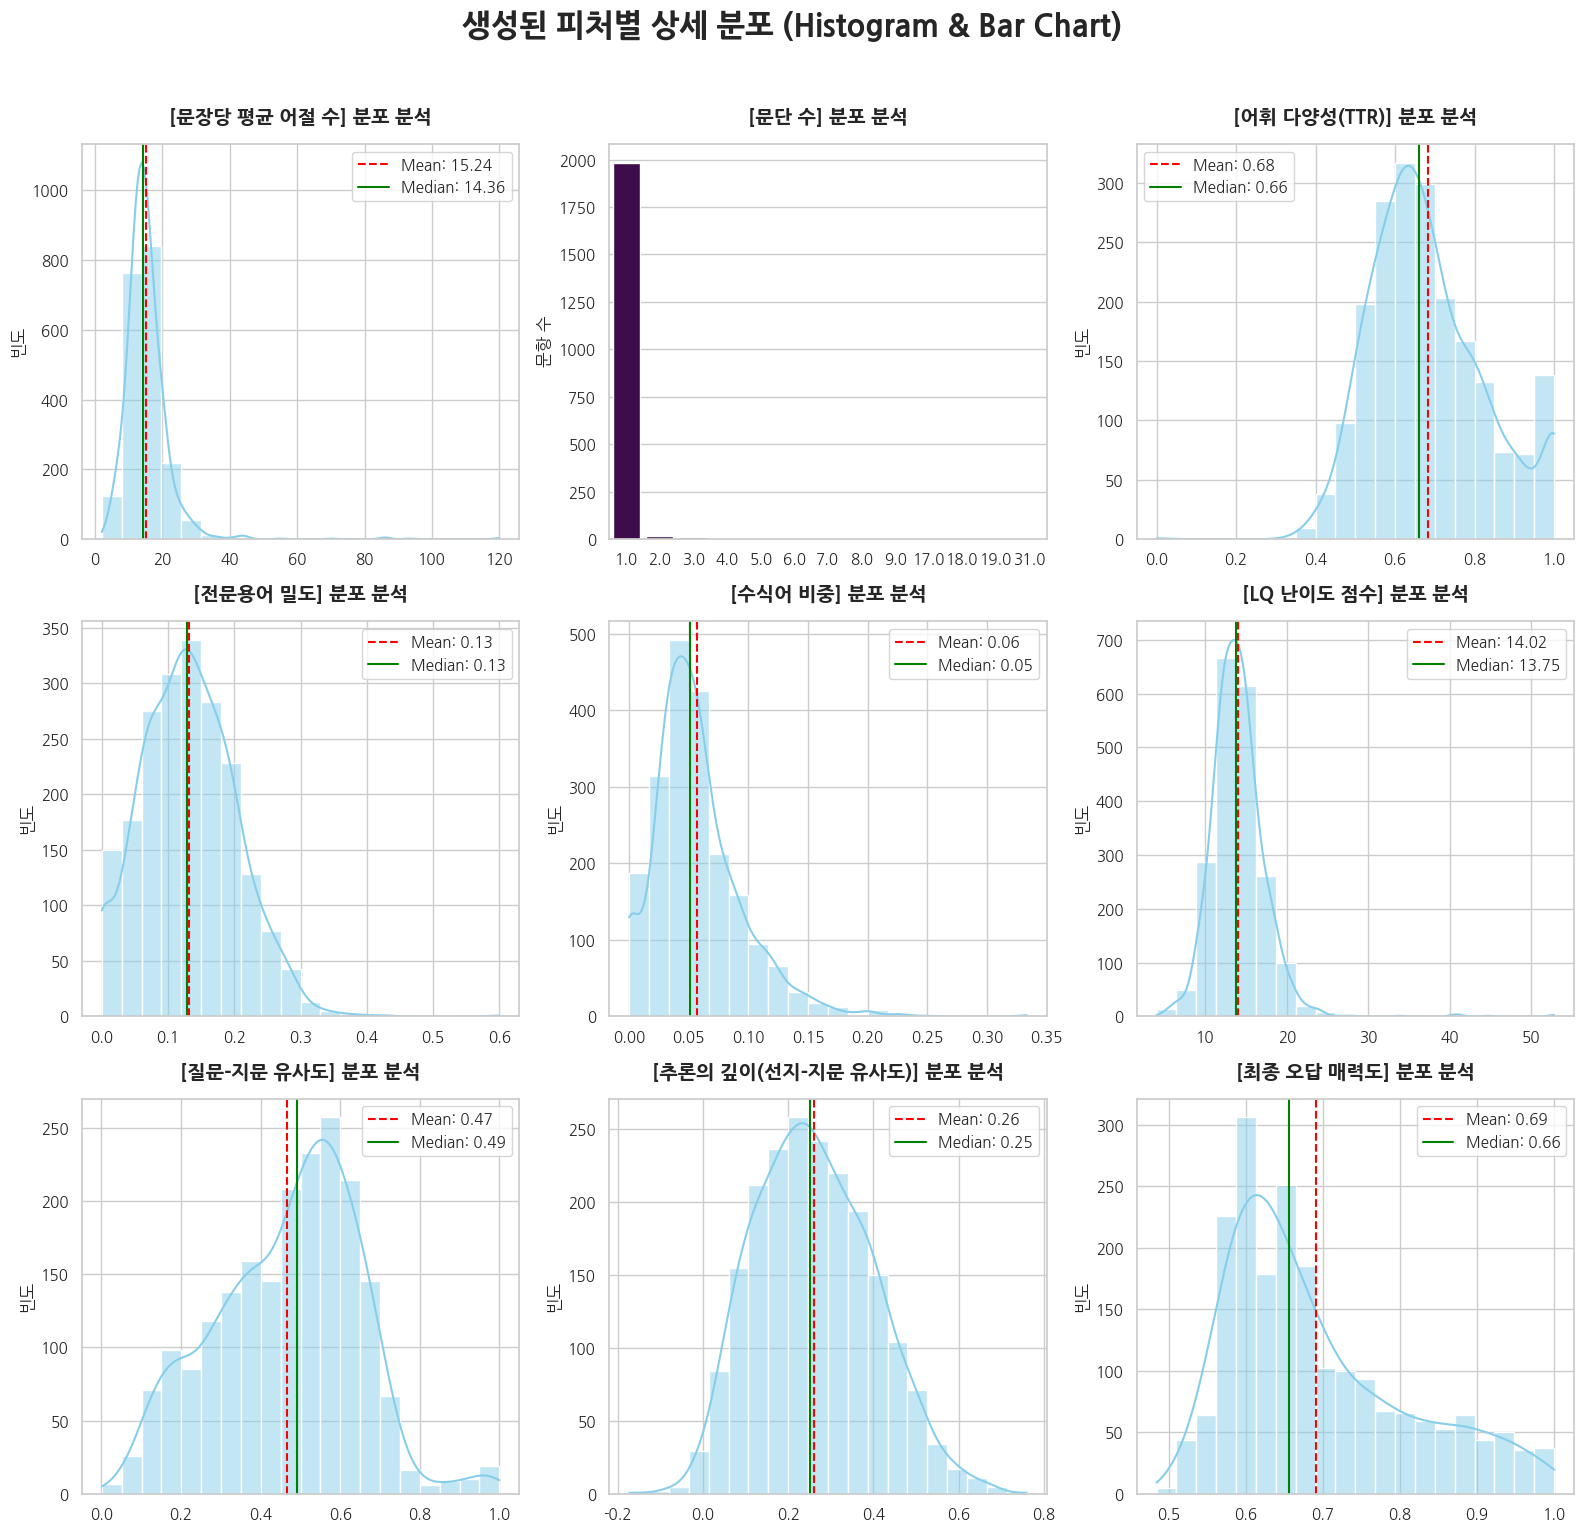

: 

In [ ]:
# 1. 한글 폰트 및 스타일 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid", font='NanumGothic')

# 2. 한글 라벨 및 차트 유형 설정
# 수치형(hist)과 범주형(bar)을 구분하여 시각화합니다.
korean_labels = {
    'avg_words_per_sent': '문장당 평균 어절 수',
    'num_paragraphs': '문단 수',
    'lq_ttr': '어휘 다양성(TTR)',
    'lq_term_density': '전문용어 밀도',
    'lq_modifier_ratio': '수식어 비중',
    'lq_score': 'LQ 난이도 점수',
    'q_p_similarity': '질문-지문 유사도',
    'choice_p_similarity': '추론의 깊이(선지-지문 유사도)',
    'final_distractor_attractiveness': '최종 오답 매력도',
}

# 3. 데이터프레임에 존재하는 피처만 선별
features = [col for col in korean_labels.keys() if col in df.columns]

# 4. 레이아웃 설정
cols = 3  # 가로로 2개씩 배치하여 그래프를 더 크게 봅니다.
rows = (len(features) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 5))
axes = axes.flatten()

# 5. 시각화 루프
for i, col in enumerate(features):
    # 범주형 변수(문단 수, 부정 여부)는 Bar Chart(Countplot)로 시각화
    if col in ['is_negative', 'num_paragraphs']:
        sns.countplot(x=df[col], ax=axes[i], palette='viridis', hue=df[col], legend=False)
        axes[i].set_ylabel('문항 수')
        
    # 연속형 변수(점수, 유사도 등)는 Histogram + KDE로 시각화
    else:
        sns.histplot(df[col], ax=axes[i], kde=True, color='skyblue', bins=20, edgecolor='white')
        axes[i].set_ylabel('빈도')
        
        # 평균값(Mean)과 중앙값(Median) 표시
        mean_val = df[col].mean()
        median_val = df[col].median()
        axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
        axes[i].legend()

    axes[i].set_title(f"[{korean_labels[col]}] 분포 분석", fontsize=14, fontweight='bold', pad=15)
    axes[i].set_xlabel('')

# 남은 빈 서브플롯 숨기기
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('생성된 피처별 상세 분포 (Histogram & Bar Chart)', fontsize=22, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

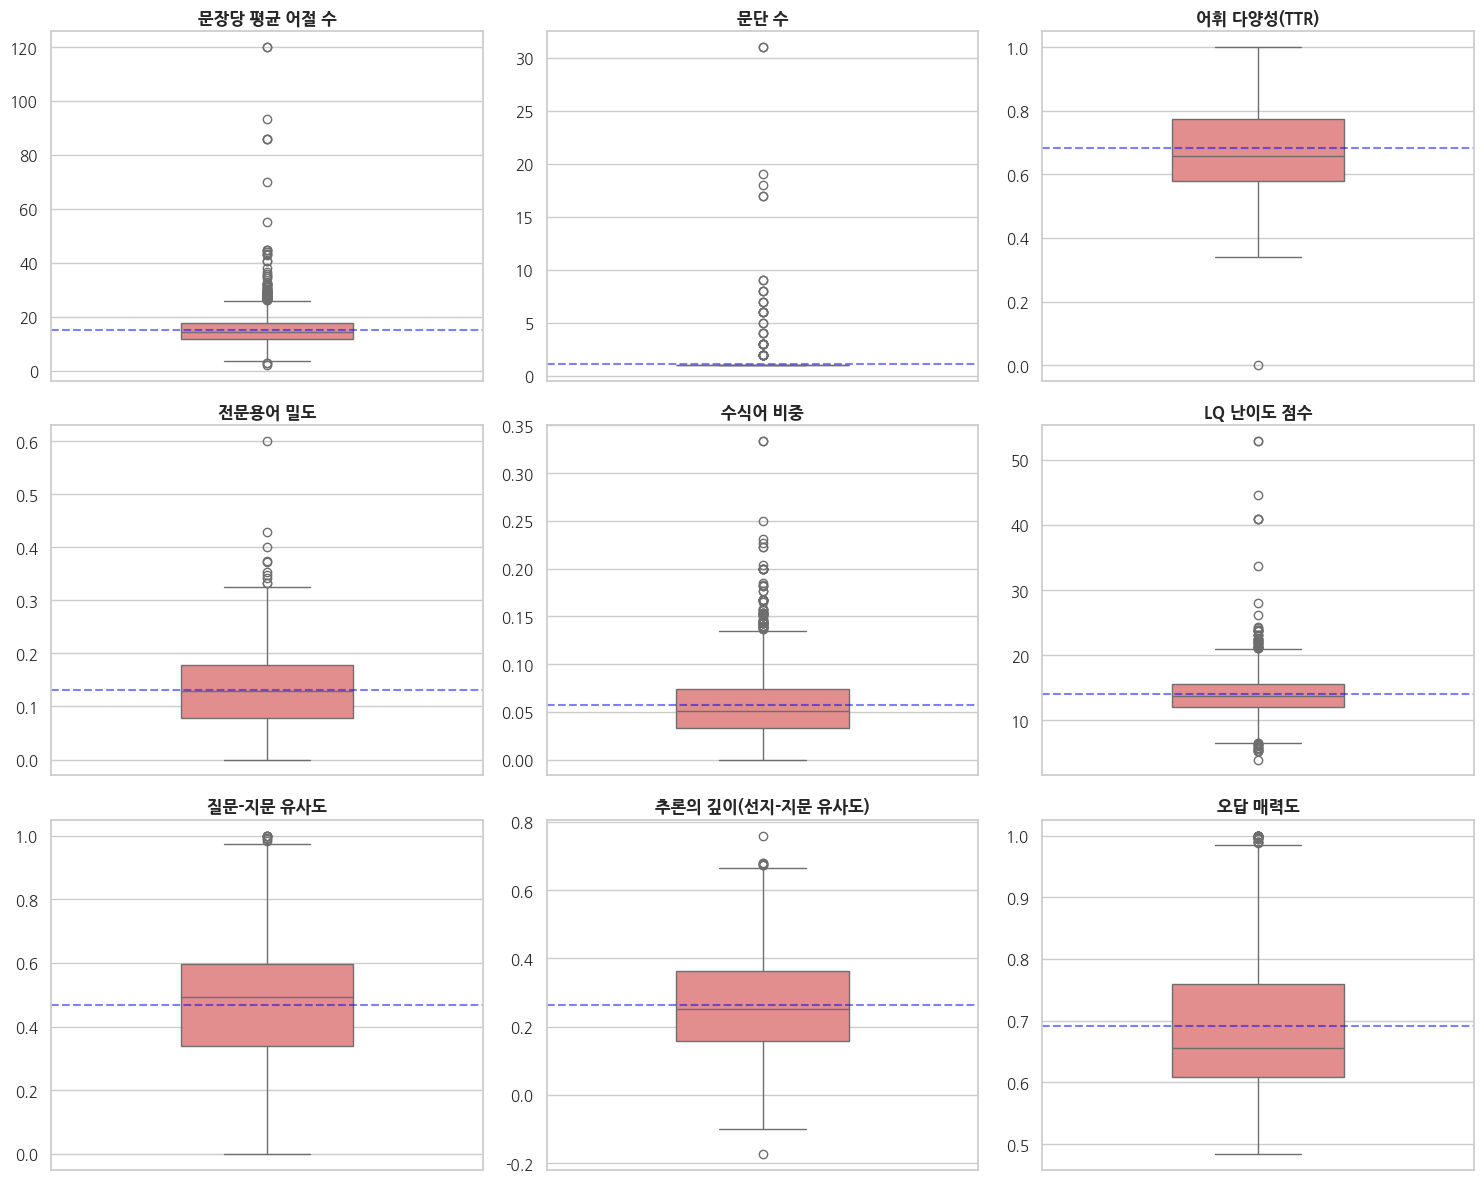

: 

In [ ]:
# 1. 한글 라벨 딕셔너리 업데이트 (choice_p_similarity 추가)
korean_labels = {
    'avg_words_per_sent': '문장당 평균 어절 수',
    'num_paragraphs': '문단 수',
    'lq_ttr': '어휘 다양성(TTR)',
    'lq_term_density': '전문용어 밀도',
    'lq_modifier_ratio': '수식어 비중',
    'lq_score': 'LQ 난이도 점수',
    'q_p_similarity': '질문-지문 유사도',
    'choice_p_similarity': '추론의 깊이(선지-지문 유사도)',  # 추가됨
    'final_distractor_attractiveness': '오답 매력도',
}

# 2. 시각화할 피처 리스트 (df에 존재하는 것만 추출)
features = [col for col in korean_labels.keys() if col in df.columns]

# 3. 서브플롯 설정
cols = 3
rows = (len(features) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()

# 4. 루프를 돌며 Boxplot 생성
for i, col in enumerate(features):
    sns.boxplot(y=df[col], ax=axes[i], color='lightcoral', width=0.4)
    axes[i].set_title(korean_labels[col], fontsize=12, fontweight='bold')
    axes[i].set_ylabel('')
    
    # 데이터 분포의 이해를 돕기 위해 평균값 표시 (선택 사항)
    mean_val = df[col].mean()
    axes[i].axhline(mean_val, color='blue', linestyle='--', alpha=0.5, label=f'Mean: {mean_val:.2f}')

# 남은 빈 칸 제거
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 이상치들만 csv로 저장
def export_outliers_to_csv(df, features, filename="outlier_questions.csv"):
    outlier_indices = set()
    outlier_details = []

    for col in features:
        # 1. IQR 계산
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # 2. 이상치 경계 설정 (보통 1.5배 기준)
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 3. 해당 피처의 이상치 행 추출
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].copy()
        
        if not outliers.empty:
            outliers['outlier_reason'] = f"{col}_이상치"
            outlier_details.append(outliers)
            outlier_indices.update(outliers.index)

    # 4. 모든 피처에서 발견된 이상치 통합 (중복 제거)
    if outlier_details:
        all_outliers = pd.concat(outlier_details).drop_duplicates(subset=['id'] if 'id' in df.columns else None)
        
        # 원본 데이터의 전체 컬럼을 포함하여 저장
        all_outliers.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"✅ 총 {len(all_outliers)}개의 이상치 문항이 '{filename}'으로 저장되었습니다.")
        
        # 간단 요약 출력
        print("\n[피처별 이상치 탐지 결과]")
        for col in features:
            Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
            IQR = Q3 - Q1
            cnt = len(df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))])
            print(f"- {col} ({korean_labels[col]}): {cnt}개")
            
    else:
        print("탐지된 이상치가 없습니다.")

# 실행
features_to_check = [col for col in korean_labels.keys() if col in df.columns]
export_outliers_to_csv(df, features_to_check)

✅ 총 248개의 이상치 문항이 'outlier_questions.csv'으로 저장되었습니다.

[피처별 이상치 탐지 결과]
- avg_words_per_sent (문장당 평균 어절 수): 78개
- num_paragraphs (문단 수): 48개
- lq_ttr (어휘 다양성(TTR)): 1개
- lq_term_density (전문용어 밀도): 10개
- lq_modifier_ratio (수식어 비중): 75개
- lq_score (LQ 난이도 점수): 54개
- q_p_similarity (질문-지문 유사도): 8개
- choice_p_similarity (추론의 깊이(선지-지문 유사도)): 7개
- final_distractor_attractiveness (최종 오답 매력도): 27개


: 

## 질문 난이도 피처 생성을 위한 피처 간 상관 계수 분석

최종 난이도 피처 = `lq_score`, `final_distractor_attractiveness`, `choice_p_similarity`, `is_negative`

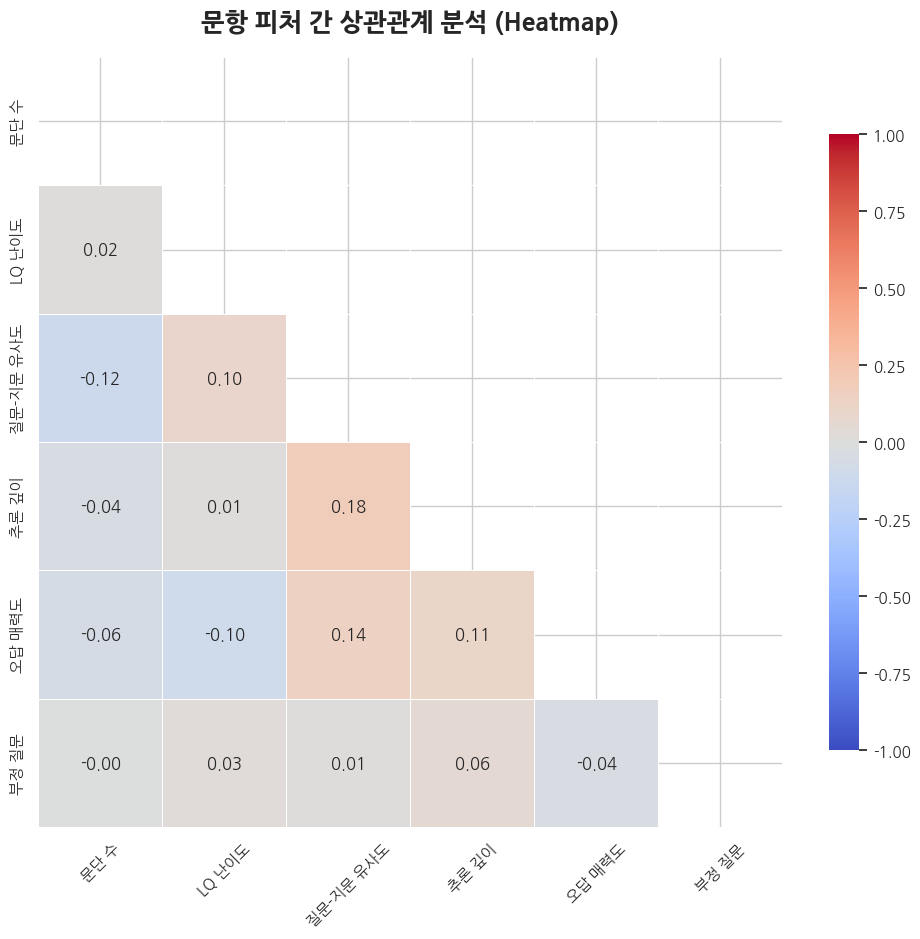

: 

In [ ]:
# 1. 상관계수를 계산할 피처 리스트
korean_labels = {
    # 'avg_words_per_sent': '문장당 어절수',
    'num_paragraphs': '문단 수',
    # 'lq_ttr': '어휘 다양성',
    # 'lq_term_density': '용어 밀도',
    # 'lq_modifier_ratio': '수식어 비중',
    'lq_score': 'LQ 난이도',
    'q_p_similarity': '질문-지문 유사도',
    'choice_p_similarity': '추론 깊이',
    'final_distractor_attractiveness': '오답 매력도',
    'is_negative': '부정 질문',
    # 'num_choices': '선지 개수'
}

# 2. 분석용 데이터프레임 생성 (존재하는 컬럼만 추출)
cols_to_use = [col for col in korean_labels.keys() if col in df.columns]
df_corr = df[cols_to_use].copy()

# 3. 컬럼명을 한글로 변경 (시각화 가독성 향상)
df_corr.columns = [korean_labels[col] for col in df_corr.columns]

# 4. 피어슨 상관계수 계산
corr_matrix = df_corr.corr()

# 5. 히트맵 시각화
plt.figure(figsize=(12, 10))
plt.rcParams['font.family'] = 'NanumGothic' # 한글 깨짐 방지

# mask: 대칭되는 윗부분을 가려 가독성 높임
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,           # 숫자 표시
            fmt=".2f",            # 소수점 둘째자리까지
            cmap='coolwarm',      # 양의 상관관계(빨강), 음의 상관관계(파랑)
            vmin=-1, vmax=1,      # 범위 고정
            center=0,
            linewidths=.5,
            cbar_kws={"shrink": .8})

plt.title('문항 피처 간 상관관계 분석 (Heatmap)', fontsize=18, pad=20, fontweight='bold')
plt.xticks(rotation=45)
plt.show()

## 클러스터링을 위한 선정된 피처들만 추출해 분포 확인

제1주성분(PC1) 설명력: 28.51%
제2주성분(PC2) 설명력: 26.80%

### 주성분별 피처 기여도(Loadings) ###
                                      PC1       PC2
lq_score                        -0.486876  0.419590
final_distractor_attractiveness  0.726367 -0.050130
choice_p_similarity              0.481061  0.589945
is_negative                     -0.062640  0.688038


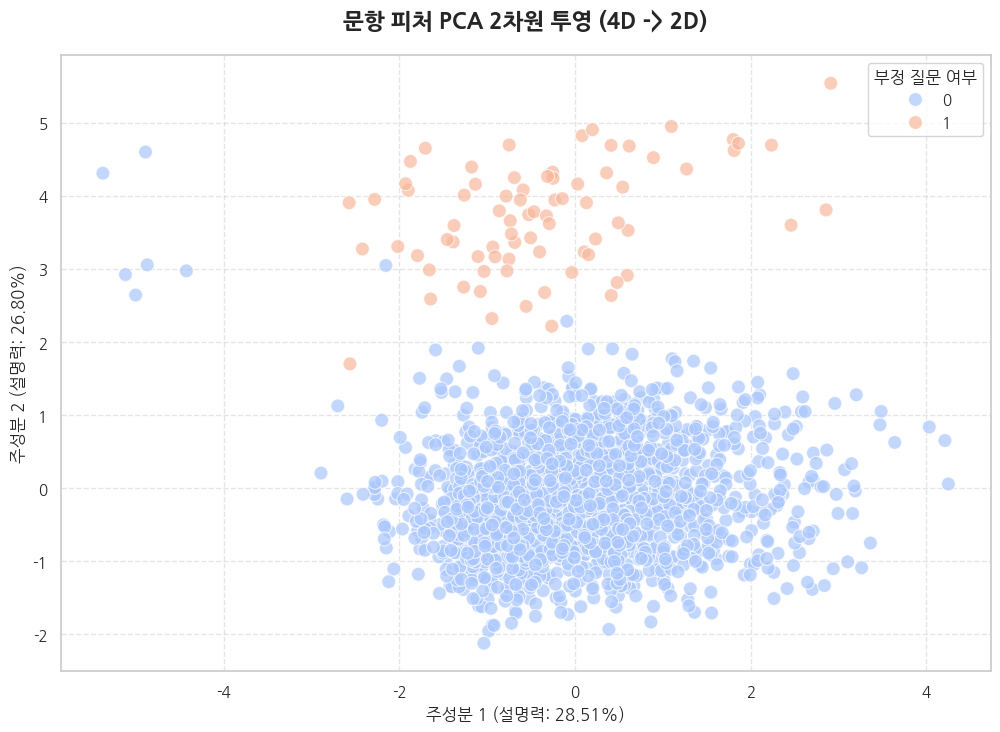

: 

In [ ]:
def plot_pca_2d(df):
    # 1. 분석에 사용할 4대 핵심 피처 추출
    features = ['lq_score', 'final_distractor_attractiveness', 'choice_p_similarity', 'is_negative']
    x_data = df[features].dropna()
    
    # 2. 데이터 표준화 (PCA는 스케일에 민감하므로 필수)
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_data)
    
    # 3. PCA 수행 (4차원 -> 2차원)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(x_scaled)
    
    # 결과를 데이터프레임에 추가
    x_data['pca_1'] = pca_result[:, 0]
    x_data['pca_2'] = pca_result[:, 1]
    
    # 설명 가능한 분산 비율 출력 (정보가 얼마나 유지되었는지 확인)
    variance_ratio = pca.explained_variance_ratio_
    print(f"제1주성분(PC1) 설명력: {variance_ratio[0]:.2%}")
    print(f"제2주성분(PC2) 설명력: {variance_ratio[1]:.2%}")

    # 4. 시각화
    plt.figure(figsize=(12, 8))
    plt.rcParams['font.family'] = 'NanumGothic'
    
    # scatter plot (색상은 부정 질문 여부로 구분)
    scatter = sns.scatterplot(
        x='pca_1', y='pca_2', 
        hue='is_negative', 
        data=x_data,
        palette='coolwarm',
        s=100, alpha=0.7, edgecolors='w'
    )
    
    plt.title('문항 피처 PCA 2차원 투영 (4D -> 2D)', fontsize=16, pad=20, fontweight='bold')
    plt.xlabel(f'주성분 1 (설명력: {variance_ratio[0]:.2%})')
    plt.ylabel(f'주성분 2 (설명력: {variance_ratio[1]:.2%})')
    plt.legend(title='부정 질문 여부', loc='upper right')
    
    # 주성분에 기여도가 높은 피처 확인 (해석을 돕기 위함)
    loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features)
    print("\n### 주성분별 피처 기여도(Loadings) ###")
    print(loadings)
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# 실행
plot_pca_2d(df)

### 비지도학습 클러스터링
해봤지만 실패

### 군집별 피처 평균값 (Cluster Profile) ###


,lq_score,final_distractor_attractiveness,choice_p_similarity,is_negative
cluster,,,,
0,13.177,0.848,0.268,0.0
1,14.477,0.670,0.305,1.0
2,14.339,0.628,0.257,0.0


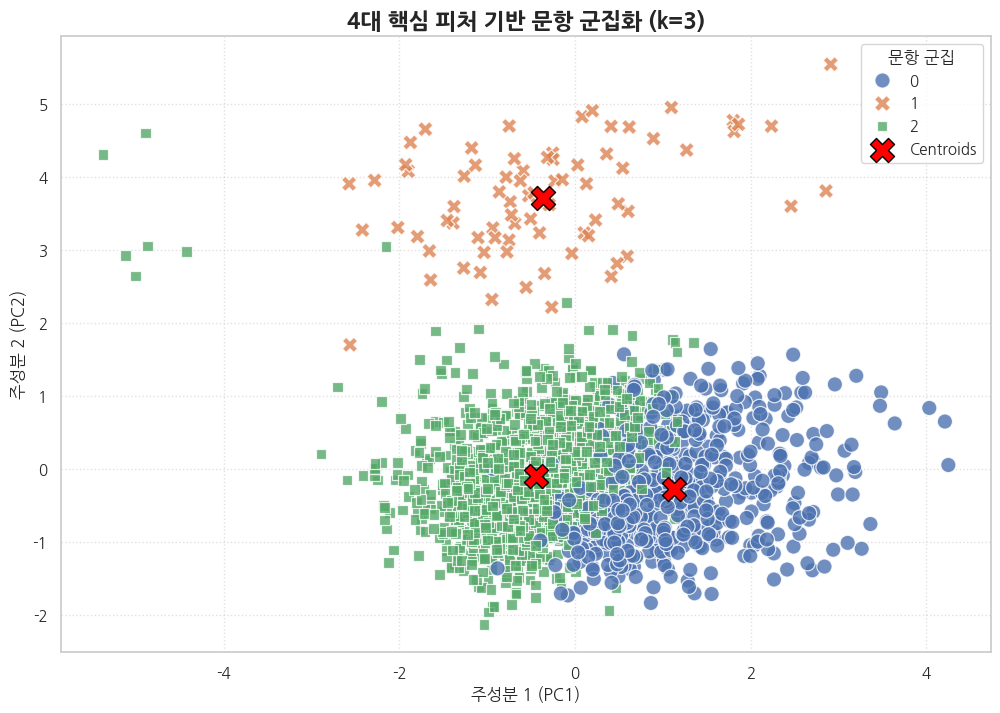

: 

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 1. 분석 피처 정의 및 전처리
# features = ['lq_score', 'final_distractor_attractiveness', 'choice_p_similarity', 'is_negative']
# x_data = df[features].dropna()

# # 데이터 표준화 (클러스터링 전 필수)
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(x_data)

# # 2. K-Means 클러스터링 수행 (k=3)
# kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
# clusters = kmeans.fit_predict(x_scaled)

# # 결과 저장
# x_data['cluster'] = clusters

# # 3. 군집별 통계량 확인 (각 군집의 성격 파악)
# cluster_profile = x_data.groupby('cluster').mean()
# print("### 군집별 피처 평균값 (Cluster Profile) ###")
# display(cluster_profile.round(3))

# # 4. PCA를 이용한 클러스터링 시각화
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(x_scaled)
# x_data['pca_1'] = pca_result[:, 0]
# x_data['pca_2'] = pca_result[:, 1]

# plt.figure(figsize=(12, 8))
# plt.rcParams['font.family'] = 'NanumGothic'

# # 군집별로 색상을 나누어 산점도 출력
# sns.scatterplot(
#     x='pca_1', y='pca_2', 
#     hue='cluster', 
#     style='cluster',
#     palette='deep',
#     data=x_data,
#     s=120, alpha=0.8, edgecolors='w'
# )

# # 군집 중심점(Centroids) 표시
# centers_scaled = kmeans.cluster_centers_
# centers_pca = pca.transform(centers_scaled)
# plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
#             s=300, c='red', marker='X', label='Centroids', edgecolors='black')

# plt.title('4대 핵심 피처 기반 문항 군집화 (k=3)', fontsize=16, fontweight='bold')
# plt.xlabel('주성분 1 (PC1)')
# plt.ylabel('주성분 2 (PC2)')
# plt.legend(title='문항 군집')
# plt.grid(True, linestyle=':', alpha=0.6)
# plt.show()

## 난이도 군집화 확인 (boundary 지정)

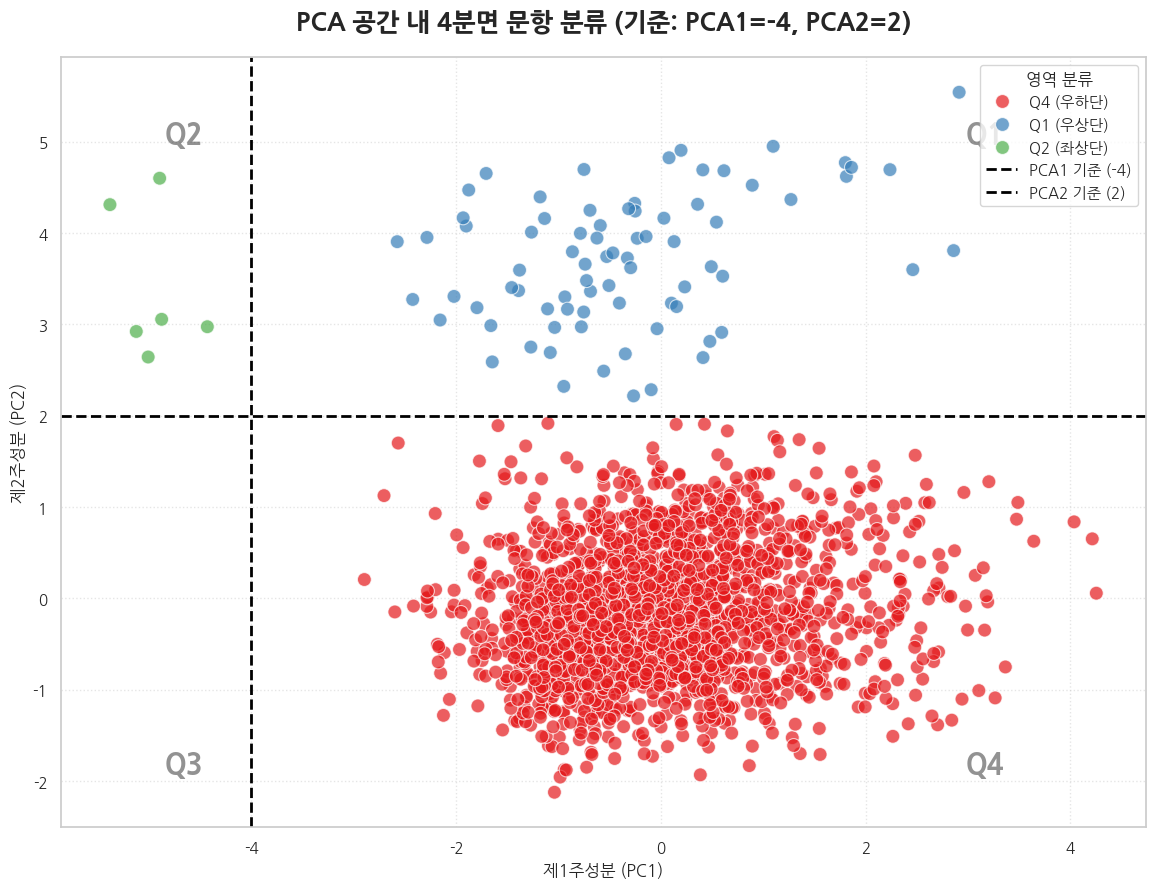

### 4분면별 피처 평균값 (Quadrant Profile) ###


,lq_score,final_distractor_attractiveness,choice_p_similarity,is_negative
quadrant,,,,
Q1 (우상단),14.829,0.672,0.317,0.974
Q2 (좌상단),45.456,0.644,0.194,0.000
Q4 (우하단),13.888,0.692,0.260,0.001



### 4분면별 문항 수 및 비중 ###


,문항 수,비중(%)
quadrant,,
Q4 (우하단),1947,95.864106
Q1 (우상단),78,3.840473
Q2 (좌상단),6,0.295421


: 

In [ ]:
def analyze_by_pca_quadrants(df):
    # 1. 핵심 4대 피처 준비 및 표준화
    features = ['lq_score', 'final_distractor_attractiveness', 'choice_p_similarity', 'is_negative']
    x_data = df[features].dropna().copy()
    
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_data)
    
    # 2. PCA 수행 (2차원 압축)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(x_scaled)
    x_data['pca_1'] = pca_result[:, 0]
    x_data['pca_2'] = pca_result[:, 1]
    
    # 3. 사용자 지정 기준값으로 4분면 나누기
    # 기준: PCA1 = -4, PCA2 = 2
    def assign_quadrant(row):
        p1, p2 = row['pca_1'], row['pca_2']
        if p1 > -4 and p2 > 2: return 'Q1 (우상단)'
        elif p1 <= -4 and p2 > 2: return 'Q2 (좌상단)'
        elif p1 <= -4 and p2 <= 2: return 'Q3 (좌하단)'
        else: return 'Q4 (우하단)'
        
    x_data['quadrant'] = x_data.apply(assign_quadrant, axis=1)

    # 4. 시각화
    plt.figure(figsize=(14, 10))
    plt.rcParams['font.family'] = 'NanumGothic'
    
    # 산점도 그리기
    sns.scatterplot(
        x='pca_1', y='pca_2', 
        hue='quadrant', 
        palette='Set1',
        data=x_data,
        s=100, alpha=0.7, edgecolors='w'
    )
    
    # 4분면 기준선 그리기
    plt.axvline(-4, color='black', linestyle='--', linewidth=2, label='PCA1 기준 (-4)')
    plt.axhline(2, color='black', linestyle='--', linewidth=2, label='PCA2 기준 (2)')
    
    # 각 영역 설명 텍스트 추가
    plt.text(x_data['pca_1'].max()*0.7, x_data['pca_2'].max()*0.9, 'Q1', fontsize=20, alpha=0.5, fontweight='bold')
    plt.text(x_data['pca_1'].min()*0.9, x_data['pca_2'].max()*0.9, 'Q2', fontsize=20, alpha=0.5, fontweight='bold')
    plt.text(x_data['pca_1'].min()*0.9, x_data['pca_2'].min()*0.9, 'Q3', fontsize=20, alpha=0.5, fontweight='bold')
    plt.text(x_data['pca_1'].max()*0.7, x_data['pca_2'].min()*0.9, 'Q4', fontsize=20, alpha=0.5, fontweight='bold')

    plt.title('PCA 공간 내 4분면 문항 분류 (기준: PCA1=-4, PCA2=2)', fontsize=18, pad=20, fontweight='bold')
    plt.xlabel('제1주성분 (PC1)')
    plt.ylabel('제2주성분 (PC2)')
    plt.legend(title='영역 분류', loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.show()

    # 5. 분면별 특징 통계 요약
    print("### 4분면별 피처 평균값 (Quadrant Profile) ###")
    quad_summary = x_data.groupby('quadrant')[features].mean()
    display(quad_summary.round(3))
    
    # 분면별 문항 수 확인
    print("\n### 4분면별 문항 수 및 비중 ###")
    counts = x_data['quadrant'].value_counts()
    percent = x_data['quadrant'].value_counts(normalize=True) * 100
    display(pd.concat([counts, percent], axis=1, keys=['문항 수', '비중(%)']))

# 실행
analyze_by_pca_quadrants(df)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def assign_problem_level_only(df):
    # 1. 핵심 피처 선택
    analysis_features = [
        'lq_score', 
        'final_distractor_attractiveness', 
        'choice_p_similarity', 
        'q_p_similarity'
    ]
    
    # 결측치 행 제외 후 복사
    temp_df = df[analysis_features].dropna().copy()
    
    # 2. 데이터 표준화 및 PCA 계산 (분류를 위한 내부 연산)
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(temp_df)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(x_scaled)
    
    # 3. 사분면 할당 로직 (PCA1=-4, PCA2=2 기준)
    def get_level(p1, p2):
        if p1 > -4 and p2 > 2:
            return 'Level_1' # 우상단
        elif p1 <= -4 and p2 > 2:
            return 'Level_2' # 좌상단
        elif p1 <= -4 and p2 <= 2:
            return 'Level_3' # 좌하단
        else:
            return 'Level_4' # 우하단

    # 리스트 생성
    levels = [get_level(p1, p2) for p1, p2 in zip(pca_result[:, 0], pca_result[:, 1])]
    
    # 4. 원본 데이터프레임에 problem_level만 추가
    df.loc[temp_df.index, 'problem_level'] = levels
    
    return df

# 실행
df = assign_problem_level_only(df)

# 결과 확인
print("### problem_level 피처 생성 완료 ###")
print(df['problem_level'].value_counts().sort_index())

### problem_level 피처 생성 완료 ###
problem_level
Level_1      44
Level_4    1987
Name: count, dtype: int64


: 

In [ ]:
df.head()

,id,paragraph,question,choices,answer,question_plus,subject,from,distractor_attractiveness,distractor_attractiveness_simhash,final_distractor_attractiveness,num_choices,avg_words_per_sent,num_paragraphs,lq_ttr,lq_term_density,lq_modifier_ratio,lq_score,q_p_similarity,choice_p_similarity,is_negative,q_type_ensemble,problem_level,pca_1,pca_2
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None,korean_history,KMMLU,0.805455,0.703125,0.858223,4,14.333333,1.0,0.883333,0.034884,0.069767,11.894186,0.467032,0.249686,0,Fact,Level_4,0.642855,-1.199339
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None,korean_history,KMMLU,0.478597,0.656250,0.656250,4,16.000000,1.0,0.941176,0.125000,0.062500,15.480882,0.170359,0.261985,1,Inference,Level_4,-1.166210,0.074395
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"[이곳에 대장도감을 설치하여 재조대장경을 만들었다., 지눌이 이곳에서 수선사 결사운...",4,None,korean_history,KMMLU,0.409381,0.656250,0.656250,4,8.000000,1.0,0.965517,0.062500,0.031250,10.215086,0.262167,0.385297,0,Inference,Level_4,-0.415527,-1.025124
3,generation-for-nlp-428,이 날 소정방이 부총관 김인문 등과 함께 기 벌포에 도착하여 백제 군사와 마주쳤다....,밑줄 친 ‘그’에 대한 설명으로 옳은 것은?,"[살수에서 수의 군대를 물리쳤다 ., 김춘추 의 신라 왕위 계승을 지원하였다 ., ...",2,None,korean_history,KMMLU,0.516401,0.750000,0.750000,4,29.000000,1.0,0.790698,0.068966,0.103448,18.656937,0.184196,0.412497,0,Inference,Level_4,-0.026612,0.546836
4,generation-for-nlp-429,"선비들 수만 명이 대궐 앞에 모여 만 동묘와 서원을 다시 설립할 것을 청하니, (가...",(가) 인물이 추진한 정책으로 옳지 않은 것은?,"[사창제를 실시하였다 ., 대전회통을 편찬하였다 ., 비변사의 기능을 강화하였다 ....",3,None,korean_history,KMMLU,0.468751,0.656250,0.656250,4,19.000000,1.0,0.931034,0.052632,0.105263,14.886751,0.337196,0.298593,1,Inference,Level_4,-0.439509,0.182762


: 

## 질문의 유형 피처 생성

In [ ]:
def categorize_question_ensemble(row):
    q_text = str(row['question']).strip()
    p_text = str(row['paragraph']).strip()
    
    # 분석용 토큰화
    tokens = kiwi.tokenize(q_text)
    token_forms = [t.form for t in tokens]
    full_text = "".join(token_forms)
    
    # 유형별 가중치 초기화
    scores = {'Fact': 0, 'Inference': 0, 'Application': 0, 'Evaluation': 0}
    
    # 1. 출발점 및 구조 분석 (질문 앞부분/지문 연계)
    if '<보기>' in q_text or '<보기>' in p_text:
        scores['Application'] += 3  # <보기>는 강력한 적용 유형 지표
    if '바탕으로' in q_text or '참고하여' in q_text:
        scores['Application'] += 2
        scores['Inference'] += 1
    if re.search(r'ㄱ|ㄴ|ㄷ|①', q_text):
        scores['Inference'] += 1  # 특정 지시 대상을 묻는 경우

    # 2. 중간 논리 부사 분석
    if '가장' in q_text:
        scores['Inference'] += 2  # '가장' 적절한 것은 최적의 추론을 요구
    if '모두' in q_text:
        scores['Fact'] += 1      # 나열된 정보의 전수 조사는 대개 사실 확인

    # 3. 최종 어미/서술어 분석 (질문 뒷부분 5어절 집중)
    tail_text = "".join(token_forms[-7:])
    
    # [비판/평가]
    if any(w in tail_text for w in ['비판', '반박', '전제', '적절한가', '한계']):
        scores['Evaluation'] += 4
    # [적용/분석]
    elif any(w in tail_text for w in ['이해', '반응', '사례', '적용']):
        scores['Application'] += 2
    # [추론]
    elif any(w in tail_text for w in ['적절', '옳은', '추론', '이유', '까닭', '의미']):
        scores['Inference'] += 2
    # [사실/일치]
    elif any(w in tail_text for w in ['일치', '부합', '언급', '내용으로']):
        scores['Fact'] += 3

    # 4. 최종 결정 (동점 시 Application > Evaluation > Inference > Fact 순)
    # 가중치가 전혀 없으면 기본값 Inference
    if max(scores.values()) == 0:
        return 'Inference'
    
    return max(scores, key=lambda k: (scores[k], ['Fact', 'Inference', 'Evaluation', 'Application'].index(k)))

# 데이터프레임 적용
df['q_type_ensemble'] = df.apply(categorize_question_ensemble, axis=1)

: 

/tmp/ipykernel_108931/308877297.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='q_type_ensemble', data=df, palette='magma', order=['Fact', 'Inference', 'Evaluation', 'Application'])
/tmp/ipykernel_108931/308877297.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='q_type_ensemble', y='lq_score', data=df, palette='magma', order=['Fact', 'Inference', 'Evaluation', 'Application'])


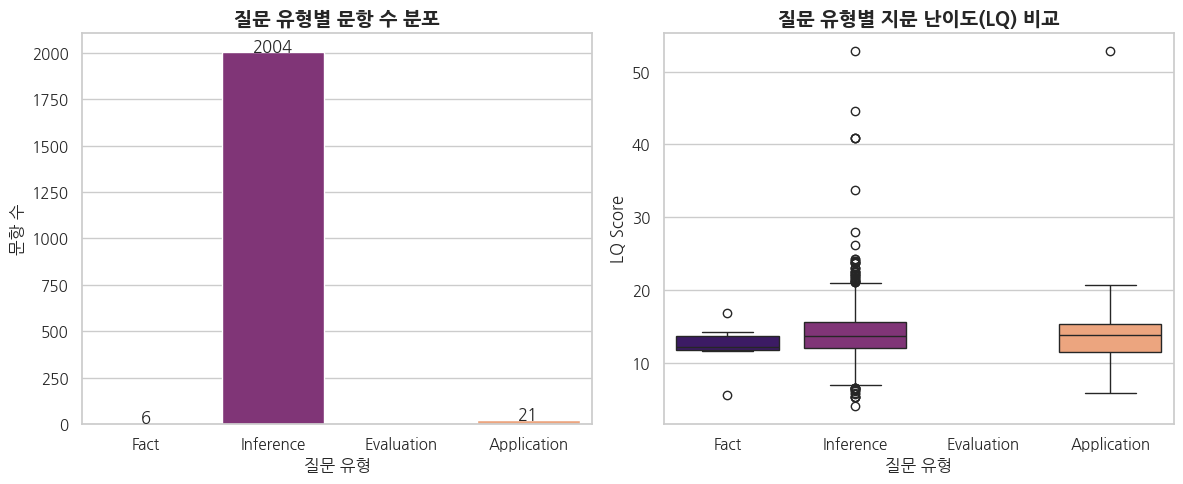

: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 질문 유형별 빈도수 (Bar Chart)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
ax = sns.countplot(x='q_type_ensemble', data=df, palette='magma', order=['Fact', 'Inference', 'Evaluation', 'Application'])
plt.title('질문 유형별 문항 수 분포', fontsize=14, fontweight='bold')
plt.xlabel('질문 유형')
plt.ylabel('문항 수')

# 바 위에 숫자 표기
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x()+0.4, p.get_height()+0.2), ha='center')

# 2. 질문 유형별 지문 난이도(LQ) 분포 (Boxplot)
plt.subplot(1, 2, 2)
sns.boxplot(x='q_type_ensemble', y='lq_score', data=df, palette='magma', order=['Fact', 'Inference', 'Evaluation', 'Application'])
plt.title('질문 유형별 지문 난이도(LQ) 비교', fontsize=14, fontweight='bold')
plt.xlabel('질문 유형')
plt.ylabel('LQ Score')

plt.tight_layout()
plt.show()

## 보기의 편향도 유형 피처 생성
극단적 진술의 보기가 정답인지 아닌지...(윤성오빠 의견 반영)

In [ ]:
import numpy as np
import pandas as pd
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

def check_extreme_phrasing_advanced(row):
    choices = row['choices'] if isinstance(row['choices'], list) else []
    answer = row.get('answer')
    
    # 데이터가 없으면 NaN 반환
    if not choices or pd.isna(answer):
        return np.nan

    # 1. 단어형 극단적 진술 키워드 (추천 리스트 반영)
    extreme_words = [
        '모두', '항상', '반드시', '오직', '결코', '전혀', '단 하나', '최고의', '무조건', # 기존
        '오로지', '단지', '특정한', '절대로', '필연적', '당연히', '결국',                # 국어/사탐 고도화
        '언제나', '예외 없이', '어떤 경우에도', '최고', '제일', '유일한',              # 전칭/비교
        '급격히', '완전히', '일관되게'                                            # 변화/단일
    ]
    
    extreme_choice_indices = []
    
    for i, choice in enumerate(choices):
        c_text = str(choice).strip()
        is_extreme = False
        
        # [A] 단어형 키워드 매칭
        if any(kw in c_text for kw in extreme_words):
            is_extreme = True
        
        # [B] 형태소 분석기를 이용한 보조사 '만' 추출
        # 문자열에 '만'이 포함된 경우에만 정밀 분석 수행 (효율성)
        if not is_extreme and '만' in c_text:
            tokens = kiwi.tokenize(c_text)
            for t in tokens:
                # '만'이라는 글자이면서 태그가 'JX'(보조사)인 경우만 인정
                if t.form == '만' and t.tag == 'JX':
                    is_extreme = True
                    break
        
        if is_extreme:
            extreme_choice_indices.append(i + 1) # 1~5번 선지 기준

    # 2. 데이터 판별 로직
    # 극단적 표현 선지가 아예 없는 경우 -> NaN
    if not extreme_choice_indices:
        return np.nan
    
    # 3. 정답 여부 확인 (사용자님 요청: 정답이면 1, 아니면 0)
    try:
        correct_answer = int(float(answer)) # 소수점 형태 대응
        if correct_answer in extreme_choice_indices:
            return 1 # 극단적 표현이 정답인 경우 (함정을 깬 사례)
        else:
            return 0 # 극단적 표현이 정답이 아닌 경우 (일반적 오답 설계)
    except (ValueError, TypeError):
        return np.nan

# 피처 적용
print("Kiwi 형태소 분석 및 극단적 진술 피처 생성 중...")
df['extreme_correct_match'] = df.apply(check_extreme_phrasing_advanced, axis=1)

# 생성 결과 확인
print("\n[ 레이블별 문항 수 확인 ]")
print(df['extreme_correct_match'].value_counts(dropna=False))

Kiwi 형태소 분석 및 극단적 진술 피처 생성 중...

[ 레이블별 문항 수 확인 ]
extreme_correct_match
NaN    1903
0.0     101
1.0      27
Name: count, dtype: int64


: 

/tmp/ipykernel_108931/2907008805.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='extreme_correct_match', data=extreme_data, palette='coolwarm')


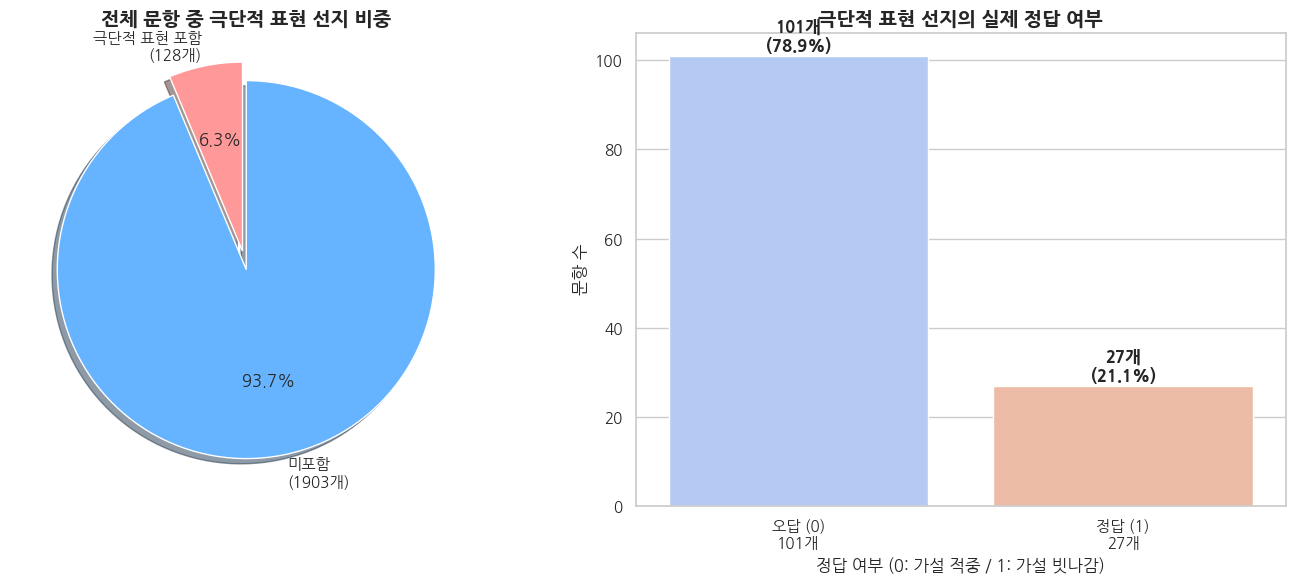

--------------------------------------------------
[분석 결과 보고 ]
- 분석 대상 전체 문항 수: 2031개
- 극단적 표현('모두', '~만' 등) 포함 문항: 128개
--------------------------------------------------
▶ 레이블 0 (가설 적중 - 오답): 101개
▶ 레이블 1 (가설 빗나감 - 정답): 27개
--------------------------------------------------
★ 가설 적중률: 78.91%
--------------------------------------------------


: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (사용 환경에 맞게 NanumGothic 또는 Malgun Gothic 선택)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 필터링 (NaN 제외 - 극단적 표현이 있는 문항만 추출)
extreme_data = df.dropna(subset=['extreme_correct_match']).copy()
total_extreme = len(extreme_data)
total_df = len(df)

# 2. 시각화
plt.figure(figsize=(14, 6))

# [왼쪽] 전체 문항 중 극단적 표현 포함 비율
plt.subplot(1, 2, 1)
pie_labels = [f'극단적 표현 포함\n({total_extreme}개)', f'미포함\n({total_df - total_extreme}개)']
pie_sizes = [total_extreme, total_df - total_extreme]
plt.pie(pie_sizes, labels=pie_labels, autopct='%1.1f%%', startangle=90, 
        colors=['#ff9999','#66b3ff'], explode=(0.1, 0), shadow=True)
plt.title('전체 문항 중 극단적 표현 선지 비중', fontsize=14, fontweight='bold')

# [오른쪽] 극단적 표현 선지의 정답 여부 (0: 오답, 1: 정답)
plt.subplot(1, 2, 2)
if total_extreme > 0:
    # 카운트 데이터 준비
    counts = extreme_data['extreme_correct_match'].value_counts().sort_index()
    
    ax = sns.countplot(x='extreme_correct_match', data=extreme_data, palette='coolwarm')
    plt.title('극단적 표현 선지의 실제 정답 여부', fontsize=14, fontweight='bold')
    plt.xticks([0, 1], [f'오답 (0)\n{counts.get(0, 0)}개', f'정답 (1)\n{counts.get(1, 0)}개'])
    plt.xlabel('정답 여부 (0: 가설 적중 / 1: 가설 빗나감)')
    plt.ylabel('문항 수')
    
    # 막대 위에 개수 및 비율 표시
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}개\n({(height/total_extreme)*100:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., height + 0.1), 
                    ha='center', va='bottom', fontsize=12, fontweight='bold')
else:
    plt.text(0.5, 0.5, '데이터 없음', ha='center', fontsize=15)

plt.tight_layout()
plt.show()

# 3. 상세 수치 요약 출력
if total_extreme > 0:
    # 각 레이블별 개수 계산
    count_0 = len(extreme_data[extreme_data['extreme_correct_match'] == 0])
    count_1 = len(extreme_data[extreme_data['extreme_correct_match'] == 1])
    accuracy = (count_0 / total_extreme) * 100
    
    print("-" * 50)
    print(f"[분석 결과 보고 ]")
    print(f"- 분석 대상 전체 문항 수: {total_df}개")
    print(f"- 극단적 표현('모두', '~만' 등) 포함 문항: {total_extreme}개")
    print("-" * 50)
    print(f"▶ 레이블 0 (가설 적중 - 오답): {count_0}개")
    print(f"▶ 레이블 1 (가설 빗나감 - 정답): {count_1}개")
    print("-" * 50)
    print(f"★ 가설 적중률: {accuracy:.2f}%")
    print("-" * 50)

In [ ]:
df.head(2)

,id,paragraph,question,choices,answer,question_plus,subject,from,distractor_attractiveness,distractor_attractiveness_simhash,final_distractor_attractiveness,num_choices,avg_words_per_sent,num_paragraphs,lq_ttr,lq_term_density,lq_modifier_ratio,lq_score,q_p_similarity,choice_p_similarity,is_negative,q_type_ensemble,problem_level,pca_1,pca_2,extreme_correct_match
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"[ㄱ, ㄴ, ㄱ, ㄷ, ㄴ, ㄹ, ㄷ, ㄹ]",2,None,korean_history,KMMLU,0.805455,0.703125,0.858223,4,14.333333,1.0,0.883333,0.034884,0.069767,11.894186,0.467032,0.249686,0,Fact,Level_4,0.642855,-1.199339,NaN
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"[고려 문종 때에 남경(南京)으로 승격되었다., 종루(鐘樓), 이현, 칠패 등에서 ...",1,None,korean_history,KMMLU,0.478597,0.656250,0.656250,4,16.000000,1.0,0.941176,0.125000,0.062500,15.480882,0.170359,0.261985,1,Inference,Level_4,-1.166210,0.074395,NaN


: 

: 